# By Miles - Data Scientist interview task

### Sam Dolman, July 2024

# Imports / Global Variables

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm

In [2]:
filename = 'ds_interview_task_data2.csv'
target_col = 'Avgpremium'

# Data Import / Basic Cleaning / Exploration

<span style="color:orange">We read in the provided csv file, format with correct data types where required, and generate some simple summary plots to understand the data in each column
</span> 

In [3]:
df = pd.read_csv(filename, low_memory = False)
df

,Quoteid,Device,Age,Maritalstatus,employmentstatus,Childrenunder16,Licencetype,Lengthlicenceheld,Noclaimsdiscount,Anyprosecutions,...,Circumstanceinformation2,Quotetime,Fueltype,Homeowner,Gender,Vehicleage,Dayofbirth,Avgpremium,Unnamed: 32,Unnamed: 33
0,1,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,09:40,Diesel,Y,M,10.0,11.0,613.96,NaN,NaN
1,2,Desktop,25.0,Single,Unemployed,No,Full UK-Manual,0.0,No NCB,No,...,NaN,13:36,Petrol,N,M,15.0,2.0,"1,466.07",NaN,NaN
2,3,Desktop,32.0,Single,Employed,No,Full UK-Manual,120.0,9 Years,No,...,NaN,15:45,Petrol,N,M,15.0,14.0,293.22,NaN,NaN
3,4,Mobile,30.0,Single,Employed,No,Full UK-Manual,27.0,1 Year,No,...,NaN,00:01,Diesel,N,M,13.0,14.0,831.66,NaN,NaN
4,5,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,09:42,Diesel,Y,M,10.0,11.0,616.76,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="color:orange">It seems that many rows at the bottom of the csv are empty, as are the final two columns. Let's drop them:
</span> 

In [4]:
df = df.dropna(how='all').iloc[:, :-2].copy()
df

,Quoteid,Device,Age,Maritalstatus,employmentstatus,Childrenunder16,Licencetype,Lengthlicenceheld,Noclaimsdiscount,Anyprosecutions,...,Claimdate2,Claimamount2,Circumstanceinformation2,Quotetime,Fueltype,Homeowner,Gender,Vehicleage,Dayofbirth,Avgpremium
0,1,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,NaN,NaN,09:40,Diesel,Y,M,10.0,11.0,613.96
1,2,Desktop,25.0,Single,Unemployed,No,Full UK-Manual,0.0,No NCB,No,...,NaN,NaN,NaN,13:36,Petrol,N,M,15.0,2.0,"1,466.07"
2,3,Desktop,32.0,Single,Employed,No,Full UK-Manual,120.0,9 Years,No,...,NaN,NaN,NaN,15:45,Petrol,N,M,15.0,14.0,293.22
3,4,Mobile,30.0,Single,Employed,No,Full UK-Manual,27.0,1 Year,No,...,NaN,NaN,NaN,00:01,Diesel,N,M,13.0,14.0,831.66
4,5,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,NaN,NaN,09:42,Diesel,Y,M,10.0,11.0,616.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463459,"463,460",Mobile,25.0,Single,Employed,No,Full UK-Manual,48.0,4 Years,No,...,NaN,NaN,NaN,17:15,Petrol,N,M,13.0,6.0,724.56
463460,"463,461",Desktop,58.0,Widowed,Employed,No,Full UK-Manual,241.0,11 Years (Currently Protected),No,...,NaN,NaN,NaN,18:02,Diesel,Y,F,6.0,9.0,433.96
463461,"463,462",Desktop,42.0,Living with partner / Common law,Employed,Yes,Full UK-Manual,180.0,12 Years,No,...,NaN,NaN,NaN,14:25,Electric,N,M,1.0,11.0,"1,222.22"
463462,"463,463",Desktop,62.0,Single,Self-Employed,No,Full UK-Manual,241.0,No NCB,No,...,NaN,NaN,NaN,18:03,Diesel,Y,M,19.0,25.0,457.99


<span style="color:orange">Next up, we check to see whether any columns have been encoded with an incorrect data type:
</span> 

In [5]:
# Check data types and summary statistics for each column:
for col in df.columns:
    print(df[col].describe())
    print('\n')

count     463464
unique    463464
top            1
freq           1
Name: Quoteid, dtype: object


count      463464
unique          6
top       Desktop
freq       235972
Name: Device, dtype: object


count    463464.000000
mean         37.310164
std          16.326457
min          16.000000
25%          23.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: Age, dtype: float64


count     463464
unique        15
top       Single
freq      201506
Name: Maritalstatus, dtype: object


count       463464
unique          18
top       Employed
freq        311916
Name: employmentstatus, dtype: object


count     463464
unique         4
top           No
freq      324373
Name: Childrenunder16, dtype: object


count             463464
unique                15
top       Full UK-Manual
freq              416913
Name: Licencetype, dtype: object


count    463336.000000
mean        122.662439
std          94.196345
min           0.000000
25%          32.000000
50%      

<span style="color:orange">**NCD, Vehicle Value, Mileage**, and **Vol Excess** need converting to integer type.

<span style="color:orange">As a quick and dirty first approach, extract any numbers from the string using regex, otherwise fill with zeros (if we had more time, would have custom treatment for special values, missing values, and other details such as protected NCD - but this is good enough for now)
</span> 

In [6]:
for col in ['Noclaimsdiscount', 'Vehiclevalue', 'Estimatedannualmileage', 'Voluntaryexcess']:
    print(df[col].value_counts()[:10])
    print('\n')
    df[col + '_clean'] = df[col].str.replace(r'\D', '', regex=True).replace('', pd.NA).fillna('0').astype(int)
    df.drop(columns = col, inplace = True)
    print(df[col + '_clean'].value_counts()[:10])
    print('\n')

Noclaimsdiscount
No NCB                             106648
1 Year                              48959
2 Years                             36104
3 Years                             28944
20+ years (Currently Protected)     24332
4 Years                             20886
5 Years                             16105
10 Years (Currently Protected)      15510
9 Years (Currently Protected)       14923
20+ years                           11975
Name: count, dtype: int64


Noclaimsdiscount_clean
0     112424
1      48991
2      36652
20     36329
3      28969
10     25803
9      25385
4      24758
5      21974
6      16180
Name: count, dtype: int64


Vehiclevalue
>40000    8750
2,000     5208
1,000     5023
1,500     4631
3,000     4109
2,500     3615
2,195     3484
5,000     3337
4,000     3284
2,295     3249
Name: count, dtype: int64


Vehiclevalue_clean
40000    9361
2000     5208
1000     5023
1500     4631
3000     4109
2500     3615
2195     3484
5000     3337
4000     3284
2295     3249
Name

<span style="color:orange">**Vehiclepurchasedate** and **Quotetime** are date/time fields encoded as strings. To get at least some use from these, we respectively extract the year/hour.
</span> 

In [7]:
df['Vehiclepurchaseyear'] = df['Vehiclepurchasedate'].str.extract(r'\/(\d{4})').fillna(0).astype(int)
df['Quotehour'] = df['Quotetime'].str.extract(r'(\d{2})').fillna(0).astype(int)
df.drop(columns = ['Vehiclepurchasedate', 'Quotetime'], inplace = True)

print(df['Vehiclepurchaseyear'].value_counts()[:10])
print('\n')
print(df['Quotehour'].value_counts()[:10])

Vehiclepurchaseyear
0       142272
2021     96995
2020     61844
2022     46913
2019     40192
2018     24880
2017     16494
2016     10471
2015      7029
2014      4505
Name: count, dtype: int64


Quotehour
14    37610
15    37388
16    31874
0     28649
13    23873
17    23014
12    21583
11    20941
10    20406
9     20374
Name: count, dtype: int64


<span style="color:orange">The **target column** also needs converting to numeric. Here, need to take care of decimal places, and also drop the three rows with missing target:

In [8]:
# encode target col as numeric
df[target_col] = df[target_col].str.replace(',', '').astype(float)
df = df.loc[~df[target_col].isna()]

df[target_col]

0          613.96
1         1466.07
2          293.22
3          831.66
4          616.76
           ...   
463459     724.56
463460     433.96
463461    1222.22
463462     457.99
463463    7340.36
Name: Avgpremium, Length: 463461, dtype: float64

<span style="color:orange">For the various **claim** columns, a thorough treatment would involve extensive feature engineering to create multiple columns such as 'number of fault claims within 1/2/3 years' etc.

<span style="color:orange">To save time we will **ignore the claim date fields**, and simply use the remaining claim fields as they come (with appropriate missing value where no claim has occured) to pick up the effect of claims on quote price. This is obviously not the best approach!

<span style="color:orange">(claim amounts will be converted to numeric, as above)

In [ ]:
# remove claim date columns
df.drop(columns = ['Claimdate1', 'Claimdate2'], inplace = True)

# transform claim amount columns to numeric
for col in ['Claimamount1', 'Claimamount2']:
    df[col] = df[col].str.replace(',', '').astype(float).fillna(0)

<span style="color:orange">Also note that many of the remaining categorical columns contain **duplicate levels**, with quotation marks - e.g. 'No' and '"No"' appearing as distinct levels. Let's quickly fix that:

In [ ]:
for col in df.select_dtypes(include=['object']).columns[1:]:
    df[col] = df[col].str.replace('"', '', regex=False)

<span style="color:orange">With the basic cleaning complete, we can now visualise the distributions:

<span style="color:orange">Everything mostly looks as we'd expect!

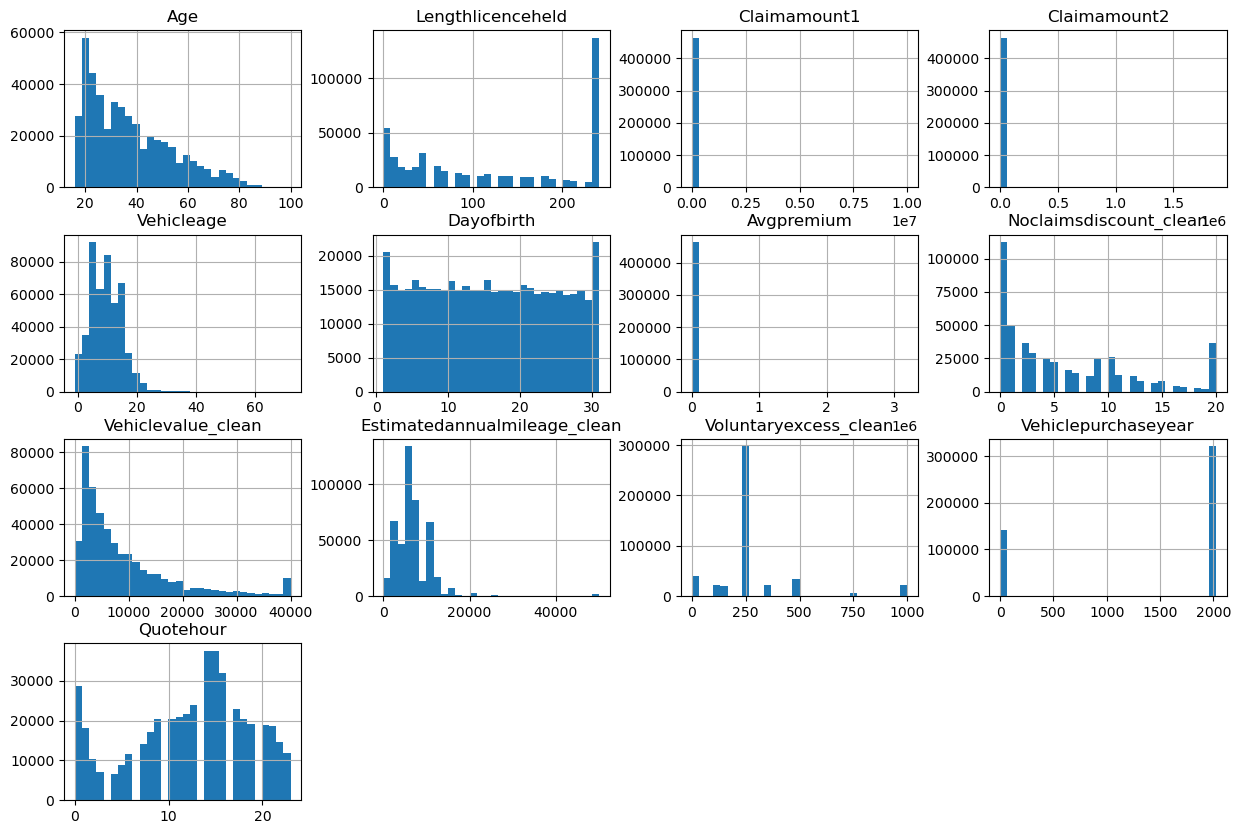

In [11]:
# Histograms for numerical columns
df.hist(bins=30, figsize=(15, 10))
plt.show()

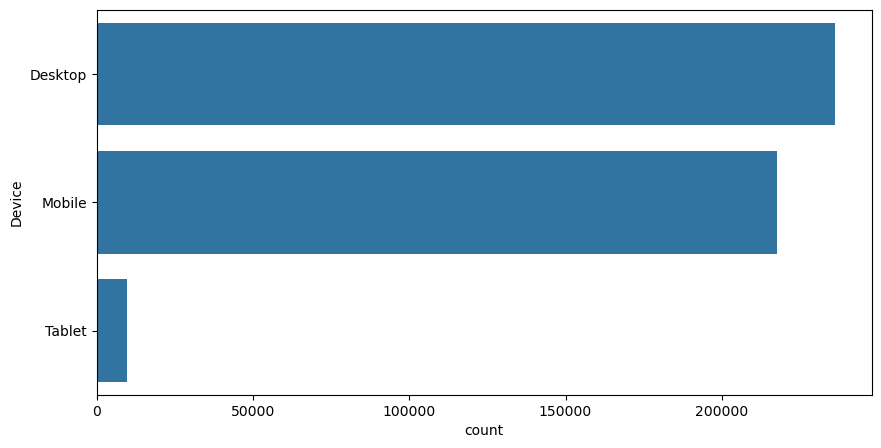

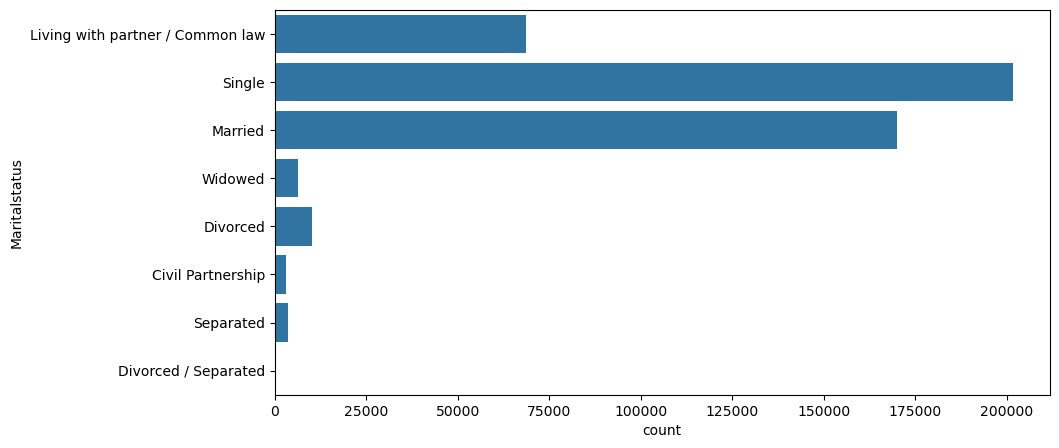

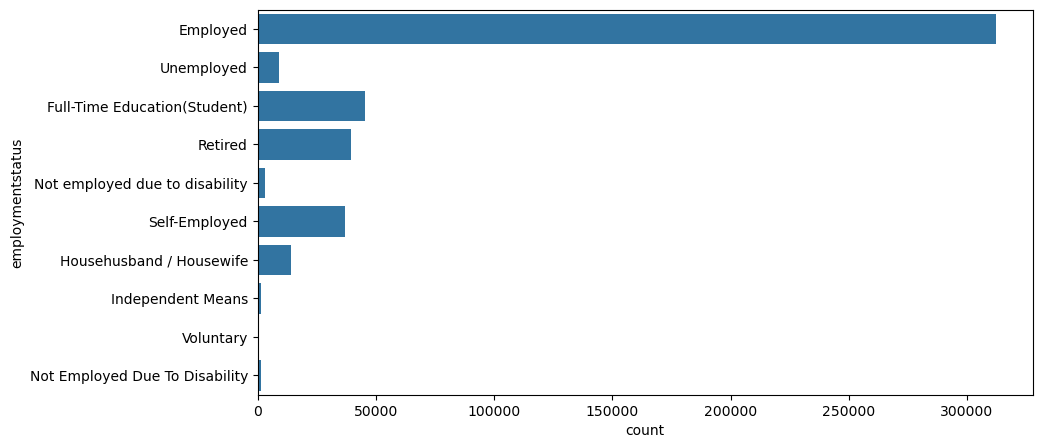

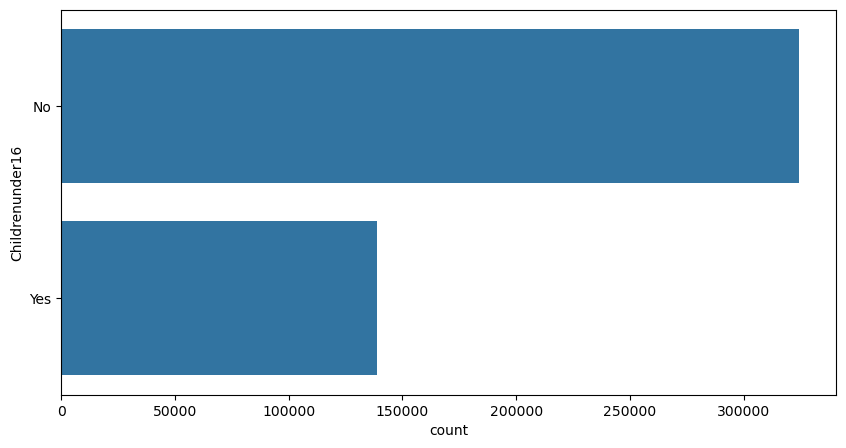

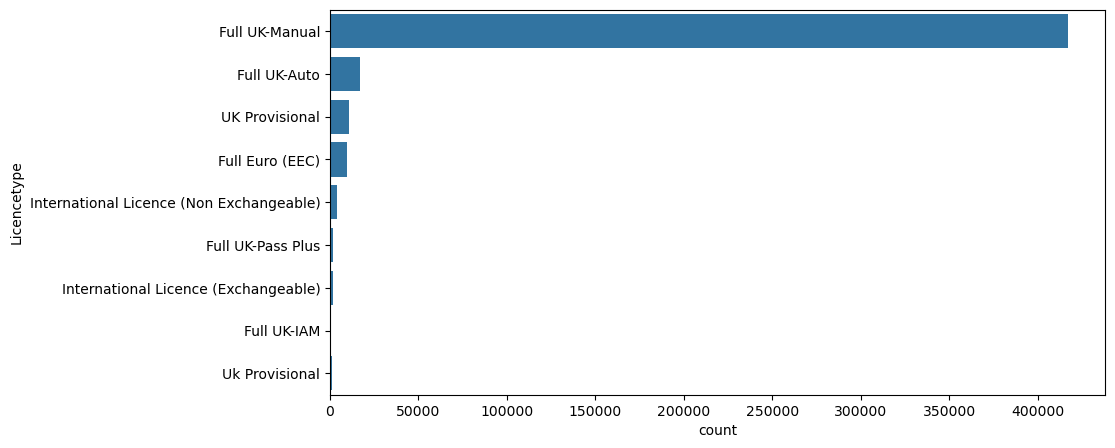

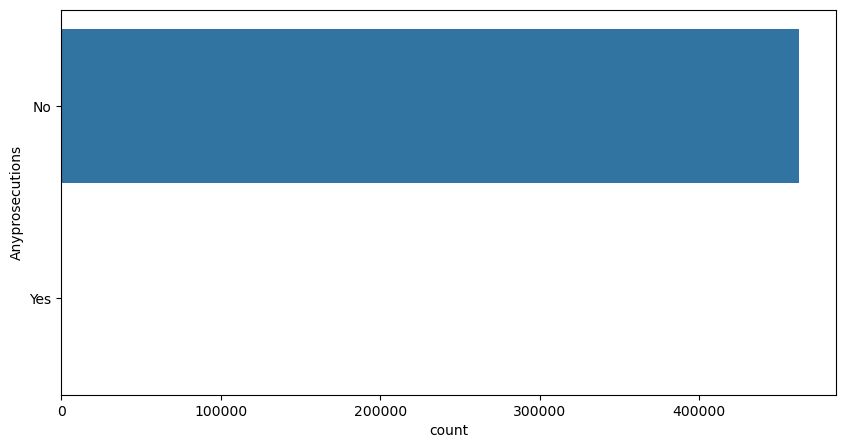

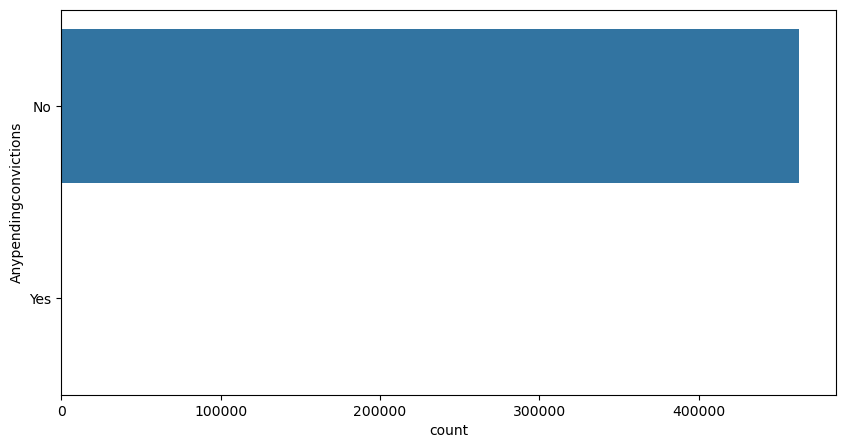

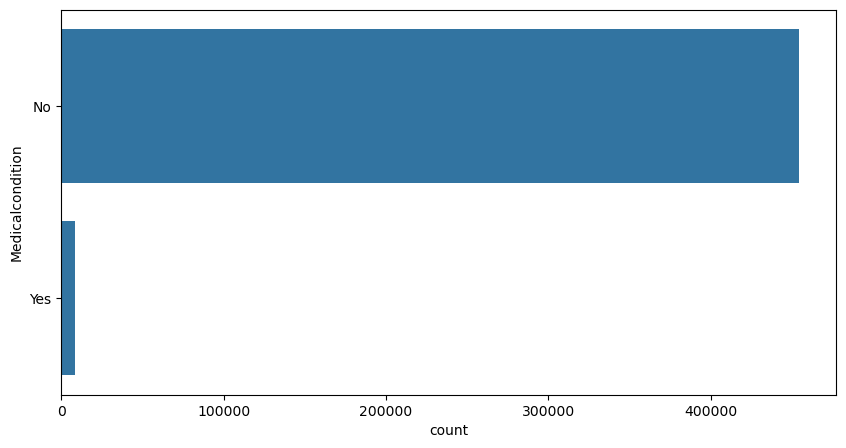

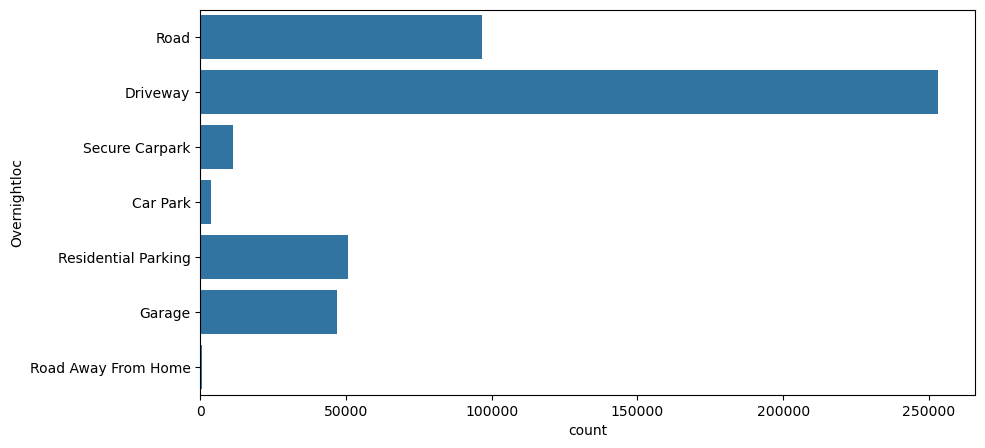

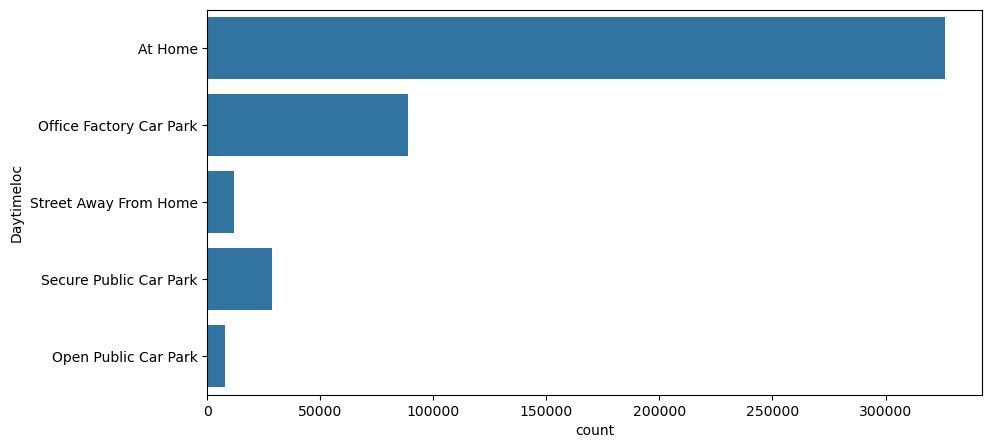

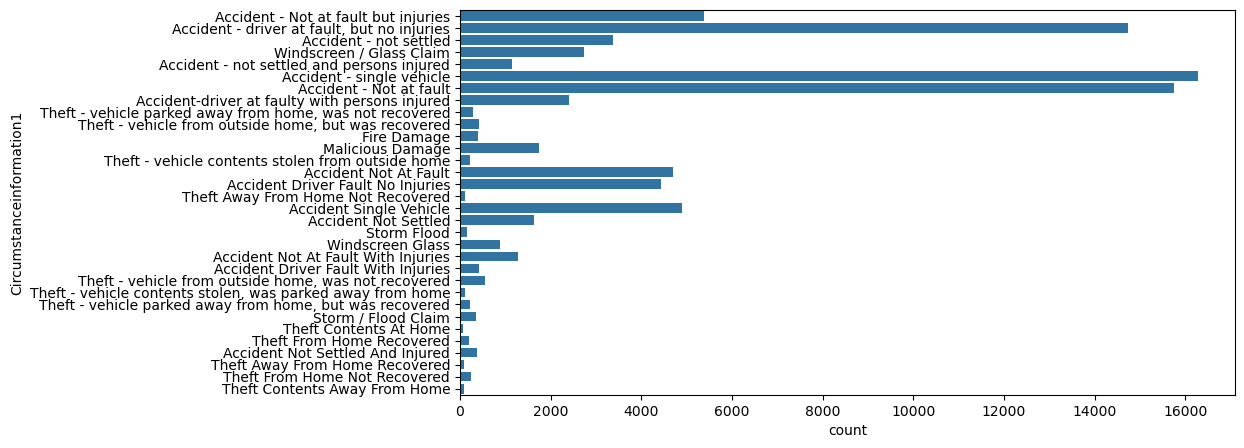

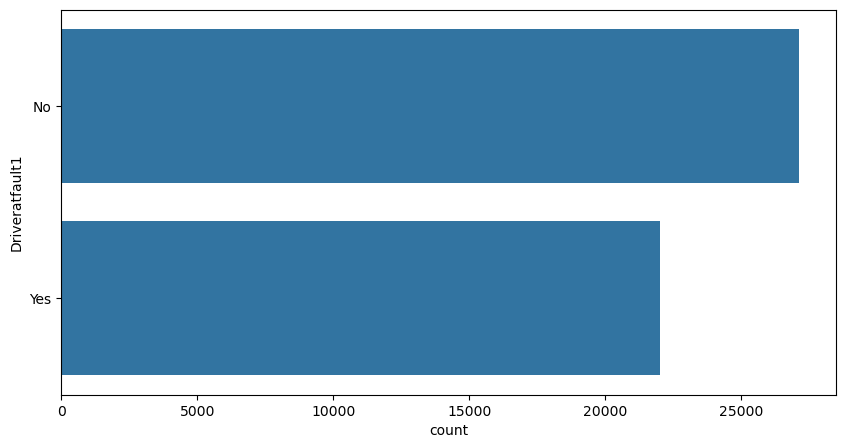

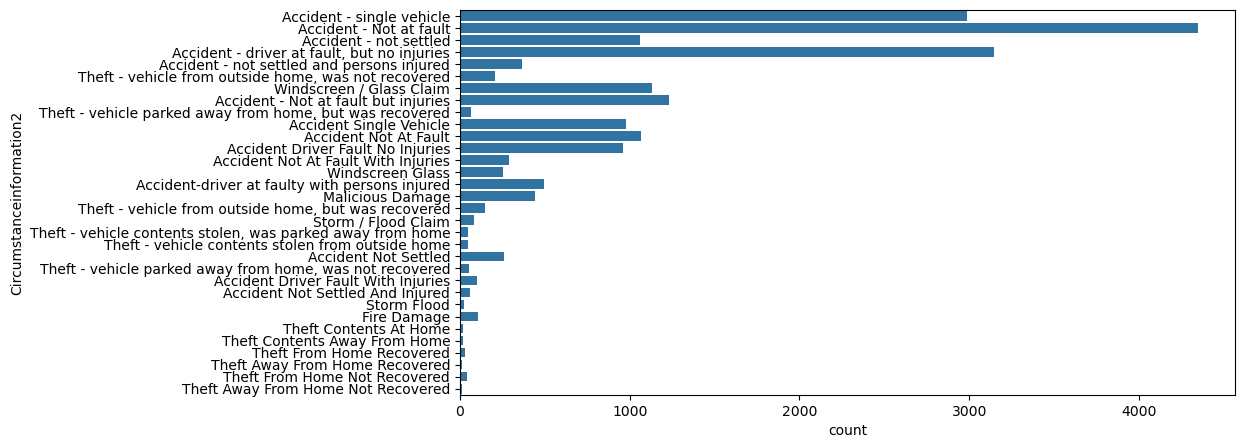

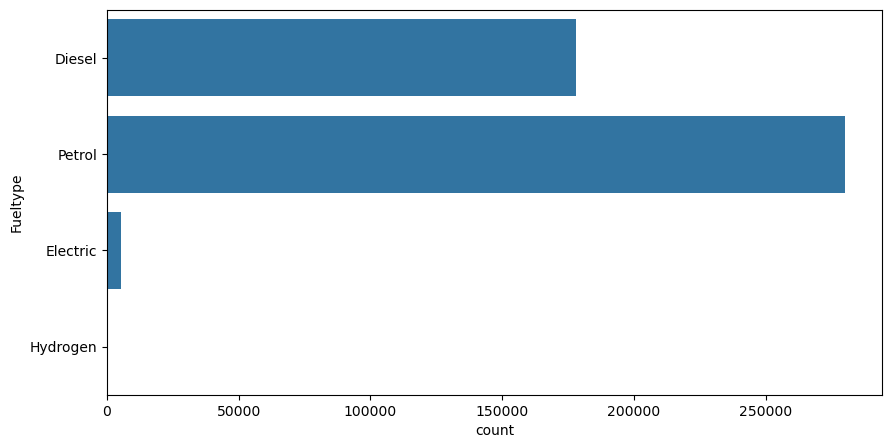

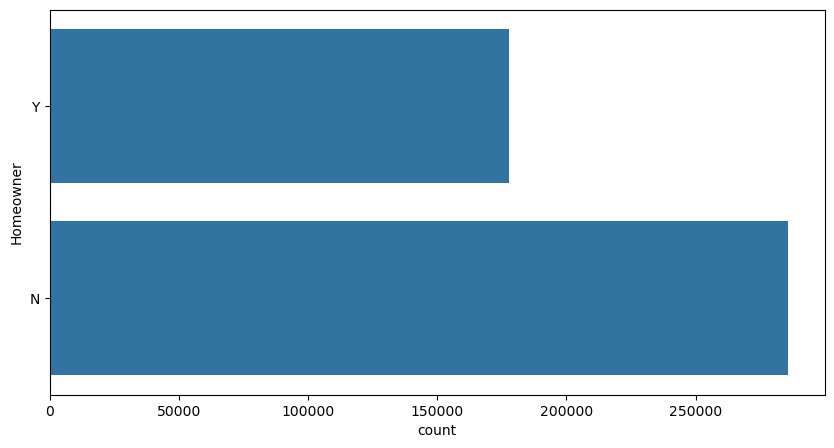

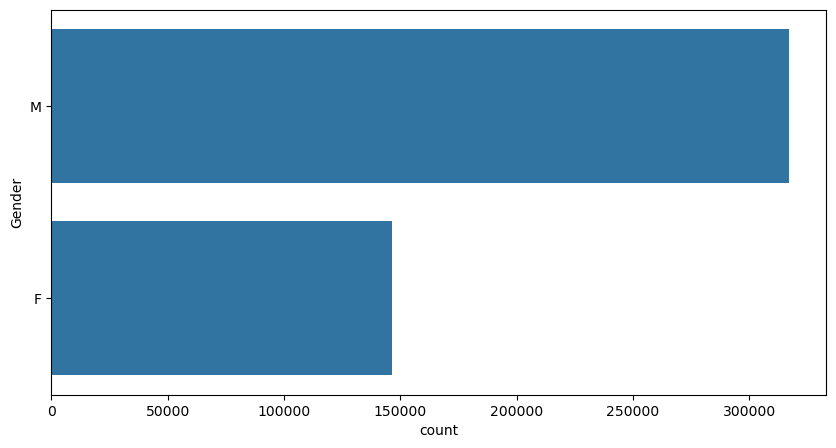

In [12]:
# Bar plots for categorical columns
for column in df.select_dtypes(include=['object']).columns[1:]:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=column, data=df)
    plt.show()

# Additional Data Prep + Feature Engineering

* Remove innapporpriate features
* Custom feature engineering
* Categorical Encoding
* Treatment of missing values
* Train/val/test split

<span style="color:orange">Some features should not be included in the model. Let's get rid of them:

In [13]:
disallowed_features = ['Gender',      # cannot use Gender to set insurance prices (FCA regs)
                       'Dayofbirth',  # we'll only use age in years, rather than exact birthday
                       'Quoteid',     # unique identifier
                      ]

df_clean = df.drop(columns = disallowed_features).copy()

<span style="color:orange">Adding in engineered features


In [14]:
# Vehicle age at purchase

# Claims summary features
# (why is diveratfault2 missing?)

<span style="color:orange"> Categorical encoding

<span style="color:orange">There are many approaches to encoding categorical features

In [15]:
# One-hot (or does lgbm not need it?)

<span style="color:orange"> Missing imputation

In [16]:
# Check for missing values
#print(df.isnull().sum())

# Handle missing values (example: fill with mean for numerical and mode for categorical)
#df.fillna(df.mean(), inplace=True)
#df.fillna(df.mode().iloc[0], inplace=True)

<span style="color:orange"> Train / val / test split

In [17]:
# note that with more complicated forms of missing imputation/feature engineering, need to beware of target leakage
# (so do it after train test split). but not an issue here

# say whast use easch for

# Model Training

* Which algorithm?
* Parameter tuning
* Early stopping
* Check for correct link function etc

In [18]:
# param tuning
# early stopping
# link function (target dist)

# Model Validation / Interpretation

<span style="color:orange"> Performance

In [19]:
# choice of metric
# goodness of fit to distn
# comparison of different models (w vs wo FE, w vs wo tuning)


<span style="color:orange"> Feature Importance

In [20]:
# talk about feature selection
# methods of FI

<span style="color:orange"> Feature Interpretations

In [21]:
# PDP, avg vs expected plots

# Further work



* Additional feature engineering:
    * Custom banding of categorical feature levels (e.g. 'Hydrogen' with 'Electric')
    * Other encoding methods (e.g. target encoding) for high cardinality features
    * Better treatment of missing values (very important!!)
    * Include external data (e.g. postcode features)
    * Explicitly encode additional interactions (e.g. age at which licence first obtained)
    * Better treatment of claims columns - number of (fault/non-fault) claims within 1/2/5 years etc
* More hyper-parameter tuning (grid search, or bayesian optimisation)
* Robust feature selection (e.g. using shuffle-feature-importance)
* Performance Comparisons against other model types (e.g. GLM)